In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plotting style
plt.style.use('default')
sns.set(style="whitegrid")

# Load the CSV file
# Replace "battery_pack.csv" with the actual filename or path to your CSV file.
df = pd.read_csv("battery_alt_dataset/regular_alt_batteries/battery00.csv")

# Display the first few rows of the dataset
df.head()


,start_time,time,mode,voltage_charger,temperature_battery,voltage_load,current_load,temperature_mosfet,temperature_resistor,mission_type
0,2022-07-19 11:10:00,0.000,0.0,0.000,0.000,NaN,NaN,NaN,NaN,NaN
1,2022-07-19 11:10:00,1.894,0.0,8.341,23.059,NaN,NaN,NaN,NaN,NaN
2,2022-07-19 11:10:00,2.814,0.0,8.340,23.059,NaN,NaN,NaN,NaN,NaN
3,2022-07-19 11:10:00,3.734,0.0,8.341,23.063,NaN,NaN,NaN,NaN,NaN
4,2022-07-19 11:10:00,4.654,0.0,8.341,23.063,NaN,NaN,NaN,NaN,NaN


In [5]:
# Define the key columns of interest
key_columns = ['time', 'mode', 'voltage_charger',
               'temperature_battery', 'voltage_load', 'current_load', 'mission_type']

# Basic statistics
print("Descriptive Statistics:")
print(df[key_columns].describe())

# Count missing values per key column
print("\nMissing Values:")
df[key_columns].isnull().sum()


Descriptive Statistics:
               time          mode  voltage_charger  temperature_battery  \
count  1.101244e+06  1.101244e+06     1.101244e+06         1.101244e+06   
mean   5.384530e+05  3.606294e-01     7.474418e+00         3.677118e+01   
std    3.113311e+05  6.504588e-01     1.026228e+00         1.642336e+01   
min    0.000000e+00 -1.000000e+00    -6.000000e-02         0.000000e+00   
25%    2.691612e+05  0.000000e+00     6.944000e+00         2.523300e+01   
50%    5.371203e+05  0.000000e+00     7.761000e+00         3.241600e+01   
75%    8.080463e+05  1.000000e+00     8.226000e+00         3.914100e+01   
max    1.079483e+06  1.000000e+00     9.176000e+00         1.023080e+02   

        voltage_load   current_load   mission_type  
count  106006.000000  106006.000000  106006.000000  
mean        6.508119      12.800680       0.729581  
std         0.705210       6.328622       0.444178  
min        -0.027000       0.150000       0.000000  
25%         6.067000       2.521000

time                        0
mode                        0
voltage_charger             0
temperature_battery         0
voltage_load           995238
current_load           995238
mission_type           995238
dtype: int64

In [8]:
# Handling missing values
# For example, forward-fill missing data (alternatively, you could choose to drop or interpolate)
df_clean = df.copy()
df_clean[key_columns] = df_clean[key_columns].ffill()

# Identify outliers using the IQR method for temperature battery and voltage charger
def find_outliers(col):
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]

outliers_temp = find_outliers('temperature_battery')
outliers_voltage = find_outliers('voltage_charger')

print("Number of temperature battery outliers:", outliers_temp.shape[0])
print("Number of voltage charger outliers:", outliers_voltage.shape[0])


Number of temperature battery outliers: 124586
Number of voltage charger outliers: 7332


/var/folders/tp/c04r6psx0w9cn41_w3lfjky00000gn/T/ipykernel_36436/1925514483.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/recepfurkanakin/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


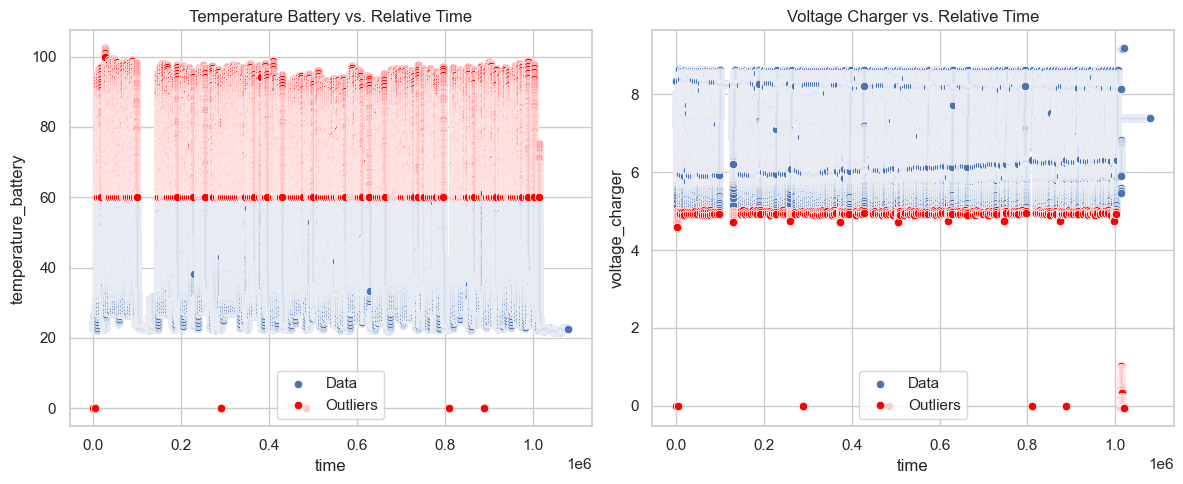

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(x='time', y='temperature_battery', data=df_clean, label='Data')
sns.scatterplot(x='time', y='temperature_battery', data=outliers_temp, color='red', label='Outliers')
plt.title('Temperature Battery vs. Relative Time')

plt.subplot(1,2,2)
sns.scatterplot(x='time', y='voltage_charger', data=df_clean, label='Data')
sns.scatterplot(x='time', y='voltage_charger', data=outliers_voltage, color='red', label='Outliers')
plt.title('Voltage Charger vs. Relative Time')

plt.tight_layout()
plt.show()

In [18]:
# Mark cycle transitions based on mode changes
# For simplicity, assume a new cycle begins each time the mode changes from a non-discharge to a discharge (-1) phase.
df_clean['cycle'] = (df_clean['mode'] == -1).astype(int).diff().fillna(0).abs().cumsum()

# Filter only discharge segments (mode == -1) for cycle analysis
discharge_cycles = df_clean[df_clean['mode'] == -1].copy()

# Calculate cycle duration, discharge capacity, and energy used for each cycle
cycle_metrics = []

# Loop over each identified cycle
for cycle, group in discharge_cycles.groupby('cycle'):
    if group.empty:
        continue
    # Duration: difference between last and first relative time (in seconds)
    duration = group['time'].iloc[-1] - group['time'].iloc[0]

    # Discharge capacity [Ah] can be approximated by integrating the current over time.
    # Assuming relative time is in seconds, convert to hours.
    capacity = np.trapezoid(group['current_load'], group['time']) / 3600  # Ah

    # Energy [Wh] is voltage * current integrated (convert seconds to hours)
    energy = np.trapezoid(group['voltage_load'] * group['current_load'], group['time']) / 3600  # Wh

    cycle_metrics.append({
        'cycle': cycle,
        'duration_s': duration,
        'discharge_capacity_Ah': capacity,
        'energy_Wh': energy
    })

cycle_df = pd.DataFrame(cycle_metrics)
cycle_df.head()

,cycle,duration_s,discharge_capacity_Ah,energy_Wh
0,1.0,3503.232,2.452570,17.802340
1,3.0,538.454,2.432879,15.685845
2,5.0,540.349,2.440274,15.798116
3,7.0,539.218,2.435775,15.760525
4,9.0,494.909,2.421935,15.353656


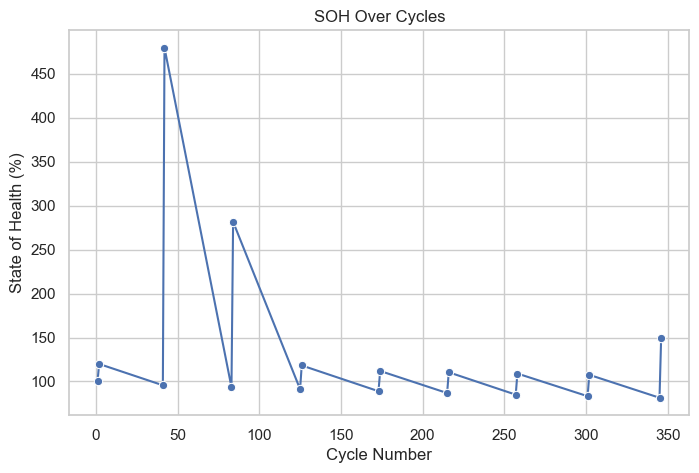

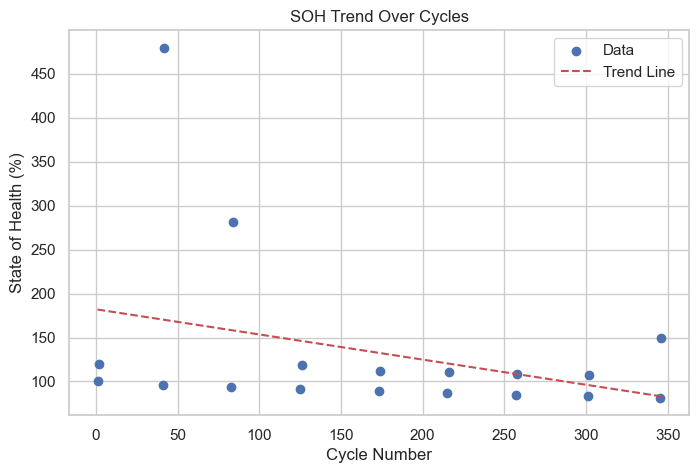

Estimated capacity loss per cycle: -0.29%


In [23]:
# Filter reference discharge cycles (mission type == 0)
ref_cycles = df_clean[df_clean['mission_type'] == 0]

# For simplicity, assume each reference cycle provides a capacity measurement.
# We group by cycle as before, using the same segmentation logic.
ref_cycle_metrics = []

for cycle, group in ref_cycles.groupby('cycle'):
    if group.empty:
        continue
    # Compute the capacity as before (Ah)
    capacity = np.trapezoid(group['current_load'], group['time']) / 3600  # Ah
    ref_cycle_metrics.append({
        'cycle': cycle,
        'capacity_Ah': capacity
    })

ref_cycle_df = pd.DataFrame(ref_cycle_metrics)

# Estimate SOH as (current capacity / initial capacity)*100
if not ref_cycle_df.empty:
    initial_capacity = ref_cycle_df['capacity_Ah'].iloc[0]
    ref_cycle_df['SOH_percent'] = (ref_cycle_df['capacity_Ah'] / initial_capacity) * 100

# Plot SOH over cycles
plt.figure(figsize=(8,5))
sns.lineplot(x='cycle', y='SOH_percent', data=ref_cycle_df, marker='o')
plt.xlabel('Cycle Number')
plt.ylabel('State of Health (%)')
plt.title('SOH Over Cycles')
plt.show()

# Fit a simple trend line (linear regression)
if not ref_cycle_df.empty:
    z = np.polyfit(ref_cycle_df['cycle'], ref_cycle_df['SOH_percent'], 1)
    p = np.poly1d(z)
    plt.figure(figsize=(8,5))
    plt.scatter(ref_cycle_df['cycle'], ref_cycle_df['SOH_percent'], label='Data')
    plt.plot(ref_cycle_df['cycle'], p(ref_cycle_df['cycle']), "r--", label='Trend Line')
    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (%)')
    plt.title('SOH Trend Over Cycles')
    plt.legend()
    plt.show()

    print("Estimated capacity loss per cycle: {:.2f}%".format(z[0]))
